In [2]:
import numpy as np
import pandas as pd
import math
from math import pi
from datetime import time, datetime
from os import path
from scipy import stats
from scipy.stats import shapiro
from statsmodels.stats.power import TTestIndPower
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
%matplotlib inline
sns.set()
red = (255/255,103/255,103/255)
blue = (52/255,128/255,255/255)

# Performance Outcomes in NFL Quarterbacks Following Shoulder Injury

### Load Data

First we load our list of QBs, that we have downloaded and selected in the other notebook:

In [5]:
case_qbs = pd.read_csv('qb-data/case_qbs.csv')
ctrl_qbs = pd.read_csv('qb-data/ctrl_qbs.csv')
inj_qbs = pd.read_csv('qb-data/injured_qbs.csv')
select_ctrls = {'Alex Smith': 'Michael Vick',
 'Andrew Luck': 'Joe Flacco',
 'Cam Newton': 'Robert Griffin III',
 'Chad Pennington': 'Tony Romo',
 'Don Majkowski': 'Erik Kramer',
 'Drew Brees': 'Peyton Manning',
 'Jay Cutler': 'Matt Schaub',
 'Jim McMahon': 'Jim Everett',
 'Jimmy Clausen': 'Kellen Clemens',
 'Kelly Holcomb': 'Donald Hollas',
 'Mark Sanchez': 'Kyle Orton',
 'Matt Moore': 'Geno Smith',
 'Matthew Stafford': 'Drew Bledsoe',
 'Rich Gannon': 'Tommy Kramer',
 'Ryan Leaf': 'Tim Couch',
 'Steve McNair': 'Donovan McNabb',
 'Tom Brady': 'Brett Favre',
 'Troy Aikman': 'John Elway',
 'Gary Danielson': 'Jim Kelly'}
inj_ctrls = {'Marc Bulger': 'Shaun Hill', 
 'Derek Anderson': 'Matt Cassel', 
 'Kyle Boller': 'Blaine Gabbert', 
 'Bruce Gradkowski': 'Brady Quinn', 
 'Jameis Winston': 'Josh Freeman',
 'Ben Roethlisberger': 'Aaron Rodgers',
 'Jim Miller': 'Hugh Millen', 
 'Scott Mitchell': 'Doug Johnson',
 'Gary Hogeboom': 'Steve Grogan', 
 'David Archer': 'Todd Blackledge', 
 'Tony Eason': 'Jeff Hostetler'}

Methods to access our CSV files of performance statistics:

In [6]:
def underscore(name):
    sep = name.find(' ')
    return name[:sep]+'_'+name[sep+1:]

def get_qb_stats(name, attempts=1, average=False):
    filesuff = '{}.csv'.format(underscore(name))
    if path.exists('qb-data/case/'+filesuff):
        df = pd.read_csv('qb-data/case/'+filesuff)
    elif path.exists('qb-data/control/'+filesuff):
        df = pd.read_csv('qb-data/control/'+filesuff)
    else:
        return 
    df = df[df['Att']>attempts]
    df.reset_index(drop=True, inplace=True)
    if average:
        return df.mean()
    return df

In [7]:
get_qb_stats('Tom Brady', average=False).tail()

,Year,Date,Age,Cmp,Att,Cmp%,Yds,TD,Int,Rate,Sk,Yds.1,Y/A,AY/A
295,2020,2020-11-23,43.112,26.0,48.0,54.17,216.0,2.0,2.0,62.5,1.0,7.0,4.50,3.46
296,2020,2020-11-29,43.118,27.0,41.0,65.85,345.0,3.0,2.0,96.1,1.0,3.0,8.41,7.68
297,2020,2020-12-13,43.132,15.0,23.0,65.22,196.0,2.0,0.0,120.9,0.0,0.0,8.52,10.26
298,2020,2020-12-20,43.139,31.0,45.0,68.89,390.0,2.0,0.0,110.4,3.0,25.0,8.67,9.56
299,2020,2020-12-26,43.145,22.0,27.0,81.48,348.0,4.0,0.0,158.3,1.0,7.0,12.89,15.85


Methods to select QB games by date, selecting all games or # of games before or after the date:

In [8]:
def format_date(date):
    month_i = date.find('/', 3)
    day_i = date.find('/')
    month = date[:day_i]
    day = date[day_i+1:month_i]
    if len(day)==1:
        day = '0'+day
    if len(month)==1:
        month = '0'+month
    newdate = date[-4:]+'-'+month+'-'+day
    return newdate

def get_qb_games(name, date, all_games=False, games=0, average=False, before=False, after=False):
    df = get_qb_stats(name)
    if df is None:
        return
    if '/' in date:
        date = format_date(date)
    i = 0
    for d in df['Date']:
        if d>=date:
            break
        else:
            i+=1 
    if all_games:
        if before and not after:
            df = df.iloc[0:i,:].reset_index(drop=True)
        elif after and not before:
            df = df.iloc[i:,:].reset_index(drop=True)
    else:
        if before:
            before_i = 0 if i-games<0 else i-games
            df = df.iloc[before_i:i,:].reset_index(drop=True)
        elif after:
            df = df.iloc[i:i+games,:].reset_index(drop=True)
        else: 
            df = df.iloc[i-games:i+games,:].reset_index(drop=True)   
    if average:
        newdf = pd.DataFrame(data={'Games': len(df), 'Age': [df['Age'].mean()], 'Cmp': [df['Cmp'].mean()], 'Att': [df['Att'].mean()], 'Cmp%': [df['Cmp%'].mean()], 'Yds': [df['Yds'].mean()], 'TD': [df['TD'].mean()], 'Int': [df['Int'].mean()], 'Rate': [df['Rate'].mean()], 'Sk': [df['Sk'].mean()], 'Yds.1': [df['Yds.1'].mean()], 'Y/A': [df['Y/A'].mean()], 'AY/A': [df['AY/A'].mean()]})
        return newdf
    else:
        return df 

In [9]:
get_qb_games('Tom Brady', '12/30/2015', games=10, before=True)

,Year,Date,Age,Cmp,Att,Cmp%,Yds,TD,Int,Rate,Sk,Yds.1,Y/A,AY/A
0,2015,2015-10-25,38.083,34.0,54.0,62.96,355.0,2.0,0.0,94.3,3.0,18.0,6.57,7.31
1,2015,2015-10-29,38.087,26.0,38.0,68.42,356.0,4.0,0.0,133.2,2.0,14.0,9.37,11.47
2,2015,2015-11-08,38.097,26.0,39.0,66.67,299.0,2.0,1.0,96.0,0.0,0.0,7.67,7.54
3,2015,2015-11-15,38.104,26.0,42.0,61.90,334.0,2.0,1.0,92.8,3.0,5.0,7.95,7.83
4,2015,2015-11-23,38.112,20.0,39.0,51.28,277.0,1.0,1.0,72.3,1.0,6.0,7.10,6.46
5,2015,2015-11-29,38.118,23.0,42.0,54.76,280.0,3.0,0.0,99.3,3.0,18.0,6.67,8.10
6,2015,2015-12-06,38.125,29.0,56.0,51.79,312.0,3.0,2.0,71.4,4.0,24.0,5.57,5.04
7,2015,2015-12-13,38.132,22.0,30.0,73.33,226.0,2.0,0.0,116.8,3.0,29.0,7.53,8.87
8,2015,2015-12-20,38.139,23.0,35.0,65.71,267.0,2.0,0.0,107.7,2.0,14.0,7.63,8.77
9,2015,2015-12-27,38.146,22.0,31.0,70.97,231.0,1.0,1.0,89.6,2.0,10.0,7.45,6.65


Method to get QB stats before or after a specified QB age:

In [10]:
def get_qb_stats_by_age(name, age, all_games=True, n_games=0, before=False, after=False):
    stats = get_qb_stats(name)
    if stats is None:
        return
    for a in stats['Age']:
        if a>age:
            qb_age = a
            break
    if age>a:
        return
    qb_date = stats[stats['Age']==qb_age]['Date'].to_string(index=False)[:] 
    if all_games:
        if after:
            result = get_qb_games(name, qb_date, all_games=True, average=True, after=True)
        else:
            result = get_qb_games(name, qb_date, all_games=True, average=True, before=True)
    else:
        if after:
            result = get_qb_games(name, qb_date, games=n_games, average=False, after=True)
        else:
            result = get_qb_games(name, qb_date, games=n_games, average=True, before=True)
    return result

In [11]:
get_qb_stats_by_age('Tom Brady', 27.5, all_games=True, before=True)

,Games,Age,Cmp,Att,Cmp%,Yds,TD,Int,Rate,Sk,Yds.1,Y/A,AY/A
0,64,25.580125,19.421875,31.53125,60.684063,217.578125,1.515625,0.8125,86.8625,2.03125,12.296875,6.84875,6.680781


Now we can get our case qbs and their controls average stats before and after their surgery age, or respective index age:

In [12]:
def compile_before_after(caseslist, controlslist):
    compare_qbs = pd.DataFrame()
    for i, row in caseslist.iterrows():
        case_prev = get_qb_stats_by_age(row.Name, row.SurgeryAge, before=True)
        case_post = get_qb_stats_by_age(row.Name, row.SurgeryAge, after=True)
        ctrl_prev = get_qb_stats_by_age(controlslist[row.Name], row.SurgeryAge, before=True)
        ctrl_post = get_qb_stats_by_age(controlslist[row.Name], row.SurgeryAge, after=True)
        case = case_prev.append(case_post)
        case['Name'] = row.Name
        ctrl = ctrl_prev.append(ctrl_post)
        ctrl['Name'] = controlslist[row.Name]
        compare_qbs = compare_qbs.append(case)
        compare_qbs = compare_qbs.append(ctrl)
    compare_qbs.reset_index(drop=True, inplace=True)
    cols = list(compare_qbs.columns)
    cols = cols[-1:] + cols[:-1]
    compare_qbs = compare_qbs[cols]
    return compare_qbs

In [13]:
cases_and_controls = compile_before_after(case_qbs, select_ctrls)
cases_and_controls.head()

,Name,Games,Age,Cmp,Att,Cmp%,Yds,TD,Int,Rate,Sk,Yds.1,Y/A,AY/A
0,Alex Smith,30,22.115333,14.500000,26.600000,55.359667,155.966667,0.633333,1.033333,65.130000,2.666667,16.600000,5.914000,4.574667
1,Alex Smith,140,30.130007,19.942857,31.142857,64.533857,220.021429,1.271429,0.542857,92.314286,2.485714,13.842857,7.185571,7.294429
2,Michael Vick,43,22.765023,11.906977,22.209302,53.791163,153.930233,0.837209,0.604651,78.306977,2.534884,15.093023,6.885116,6.555116
3,Michael Vick,85,29.514729,15.211765,26.552941,57.080353,186.352941,1.141176,0.729412,82.440000,2.423529,14.435294,7.050353,6.871059
4,Andrew Luck,70,24.857086,22.428571,37.871429,59.812429,272.542857,1.885714,0.971429,88.327143,2.228571,14.142857,7.285571,7.185143


Lets split them up into individual DataFrames for now:

In [14]:
def get_case_control_prev_post(caseslist, controlslist):
    compare = compile_before_after(caseslist, controlslist)
    droplist = []
    for i in range(len(compare)):
        if i not in range(3,len(compare),4):
            droplist.append(i)
    ctrl_post = compare.drop(index=droplist)
    droplist = []
    for i in range(len(compare)):
        if i not in range(2,len(compare),4):
            droplist.append(i)
    ctrl_prev = compare.drop(index=droplist)
    droplist = []
    for i in range(len(compare)):
        if i not in range(1,len(compare),4):
            droplist.append(i)
    case_post = compare.drop(index=droplist)
    droplist = []
    for i in range(len(compare)):
        if i not in range(0,len(compare),4):
            droplist.append(i)
    case_prev = compare.drop(index=droplist)
    ctrl_post.reset_index(drop=True, inplace=True)
    ctrl_prev.reset_index(drop=True, inplace=True)
    case_post.reset_index(drop=True, inplace=True)
    case_prev.reset_index(drop=True, inplace=True)
    return case_prev, case_post, ctrl_prev, ctrl_post

In [15]:
case_prev, case_post, ctrl_prev, ctrl_post = get_case_control_prev_post(case_qbs, select_ctrls)
case_prev.head()

,Name,Games,Age,Cmp,Att,Cmp%,Yds,TD,Int,Rate,Sk,Yds.1,Y/A,AY/A
0,Alex Smith,30,22.115333,14.500000,26.600000,55.359667,155.966667,0.633333,1.033333,65.130000,2.666667,16.600000,5.914000,4.574667
1,Andrew Luck,70,24.857086,22.428571,37.871429,59.812429,272.542857,1.885714,0.971429,88.327143,2.228571,14.142857,7.285571,7.185143
2,Cam Newton,93,24.641366,18.387097,31.483871,58.929032,234.107527,1.462366,0.838710,88.080645,2.376344,18.290323,7.569247,7.420538
3,Chad Pennington,41,26.918659,17.512195,26.609756,63.908537,197.341463,1.292683,0.658537,93.358537,1.634146,10.000000,7.691707,7.488293
4,Don Majkowski,44,24.859818,16.704545,30.113636,53.530909,208.659091,1.159091,1.045455,73.731818,2.727273,15.886364,6.847955,5.980909


In [16]:
inj_prev, inj_post, inj_ctrl_prev, inj_ctrl_post = get_case_control_prev_post(inj_qbs, inj_ctrls)

# Output QB Stats

Get the QB passer rating prior to surgery:

In [17]:
case_prev[['Name','Rate']]

,Name,Rate
0,Alex Smith,65.130000
1,Andrew Luck,88.327143
2,Cam Newton,88.080645
3,Chad Pennington,93.358537
4,Don Majkowski,73.731818
5,Drew Brees,85.933898
6,Jay Cutler,86.086331
7,Jim McMahon,81.054000
8,Jimmy Clausen,56.384615
9,Kelly Holcomb,73.268421


Get QB performance metric means and standard deviations:

In [18]:
cohort = inj_ctrl_post
for metric in ['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']:
    print('%0.4f'%cohort[metric].mean()+' +/- '+'%0.4f'%cohort[metric].std())

76.9540 +/- 11.8350
14.7846 +/- 4.3202
25.9278 +/- 6.1679
56.0140 +/- 5.6810
173.4442 +/- 51.0495
0.9758 +/- 0.5093
0.7395 +/- 0.2855
1.9950 +/- 0.5334
13.2433 +/- 3.5240
6.5251 +/- 0.6900
5.9338 +/- 1.2980


Get difference in pre/post performance

In [19]:
for metric in ['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']:
    diff = inj_ctrl_post[metric]-inj_ctrl_prev[metric]
    print('%0.4f'%diff.mean()+' +/- '+'%0.4f'%diff.std())

-0.0600 +/- 6.6877
0.9437 +/- 4.7622
2.0128 +/- 7.6151
-1.3578 +/- 4.7623
9.0099 +/- 46.6216
-0.0240 +/- 0.3253
-0.1636 +/- 0.3235
-0.0432 +/- 1.0923
-0.0413 +/- 6.4434
-0.4008 +/- 0.5816
0.3455 +/- 1.3582


### Output QB Tables

In [20]:
surg_qbs = case_qbs
surg_qbs['Control'] = list(select_ctrls.values())
new_cols = ['Name', 'Birthday', 'Year', 'Age', 'Surgery', 'SurgeryAge', 'Experience', 'Control']
surg_qbs = surg_qbs[new_cols]
surg_qbs.head()

,Name,Birthday,Year,Age,Surgery,SurgeryAge,Experience,Control
0,Alex Smith,5/7/1984,2005,21,11/6/2008,24.517808,3,Michael Vick
1,Andrew Luck,9/12/1989,2012,23,1/19/2017,27.372603,5,Joe Flacco
2,Cam Newton,5/11/1989,2011,22,3/30/2017,27.904110,6,Robert Griffin III
3,Chad Pennington,6/26/1976,2000,24,2/4/2005,28.630137,5,Tony Romo
4,Don Majkowski,2/25/1964,1987,23,12/13/1990,26.816438,3,Erik Kramer


In [21]:
nonsurg_qbs = inj_qbs
nonsurg_qbs['Control'] = list(inj_ctrls.values())
nonsurg_qbs = nonsurg_qbs[new_cols]
nonsurg_qbs.head()

,Name,Birthday,Year,Age,Surgery,SurgeryAge,Experience,Control
0,Marc Bulger,4/5/1977,2002,25,10/17/2005,28.553425,3,Shaun Hill
1,Derek Anderson,6/15/1983,2006,23,12/26/2006,23.547945,0,Matt Cassel
2,Kyle Boller,6/17/1981,2003,22,8/16/2008,27.183562,5,Blaine Gabbert
3,Bruce Gradkowski,1/27/1983,2006,23,11/28/2010,27.854795,4,Brady Quinn
4,Jameis Winston,1/6/1994,2015,21,10/15/2017,23.789041,2,Josh Freeman


In [22]:
surg_qbs.to_csv('qb-data/surg_qb_table.csv')
nonsurg_qbs.to_csv('qb-data/nonsurg_qb_table.csv')

### Verify Normal Distribution

Lets take the whole population of NFL QBs - 269 in total, and look at the distribution of statistics:

In [23]:
def get_all_qb_career_stats(caseslist, controlslist):
    all_qbs = get_qb_stats('Alex Smith', average=True)
    all_qbs = all_qbs.to_frame().T
    for i, row in caseslist.iterrows():
        qb_stats = get_qb_stats(row.Name, average=True)
        if i != 0:
            all_qbs = all_qbs.append(qb_stats, ignore_index=True)
    for i, row in controlslist.iterrows():
        qb_stats = get_qb_stats(row.Name, average=True)
        if stats is not None:
            all_qbs = all_qbs.append(qb_stats, ignore_index=True)
    return all_qbs

In [24]:
all_qb_stats = get_all_qb_career_stats(case_qbs, ctrl_qbs)

In [25]:
stat_names = {'Games': 'Games', 'Age': 'Age', 'Cmp': 'Pass Completions', 'Att': 'Pass Attempts', 'Cmp%': 'Pass Completion Percentage', 
             'Yds': 'Passing Yards', 'TD': 'Passing Touchdowns', 'Int': 'Interceptions', 'Rate': 'Passer Rating', 'Sk': 'Sacks', 
             'Yds.1': 'Yards Lost to Sacks', 'Y/A': 'Yards per Pass Attempt', 'AY/A': 'Adjusted Yards per Pass Attempt'}

In [26]:
def plot_hist_by_var(all_qbs, var):
    plt.figure(figsize=(10,6))
    mu, sigma = all_qbs[var].mean(), all_qbs[var].std()
    n, bins, patches = plt.hist(all_qbs[var], 30, density=True, alpha=0.75, color=blue)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), color=red)
    plt.xlabel(stat_names[var])
    plt.ylabel('Frequency')
    plt.title('Distribution of QB {}'.format(stat_names[var]))
    plt.show()

We can see that the average Passer Rating for the entire population of NFL QBs follows a normal distribution quite well:

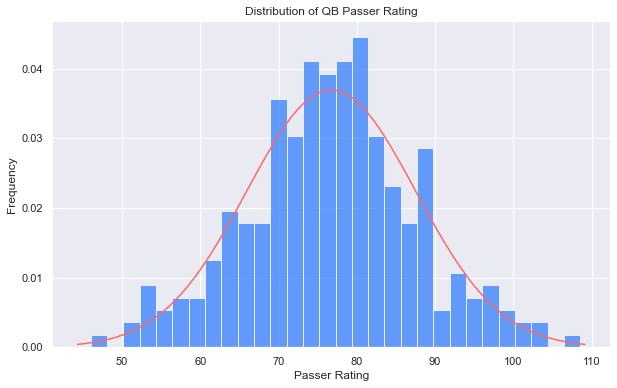

In [27]:
plot_hist_by_var(all_qb_stats, 'Rate')

We can plug in other performance statistics we capture to check those too, let's try pass attempts:

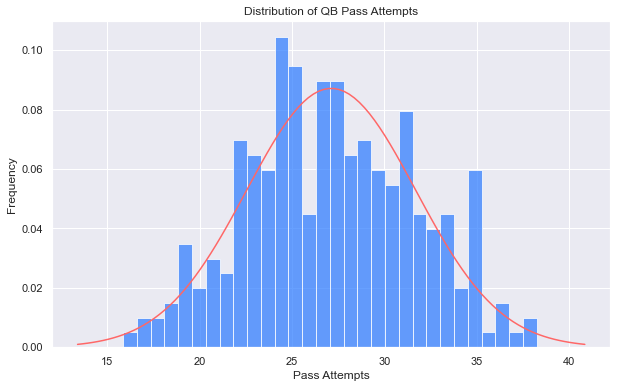

In [28]:
plot_hist_by_var(all_qb_stats, 'Att')

We can also check the distribution of our samples, the case and control QBs. We can do this using a Q-Q plot, which plots two sets of quantiles together so we can visually check if the dependent variable fits a normal distribution. This is important to verify so that we can make claims of statistically significant changes when performances deviate. 

In [29]:
def probplot_by_var(qb_stats, var):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    stats.probplot(qb_stats[var], plot=plt)
    ax.get_lines()[0].set_markerfacecolor(blue)
    ax.get_lines()[1].set_color(red)
    plt.title('Probability Plot of {}'.format(stat_names[var]))
    plt.show()

Here are our case QBs passer ratings, prior to surgery, on a Q-Q plot. We can visually see that they fit the normal distribution well. 

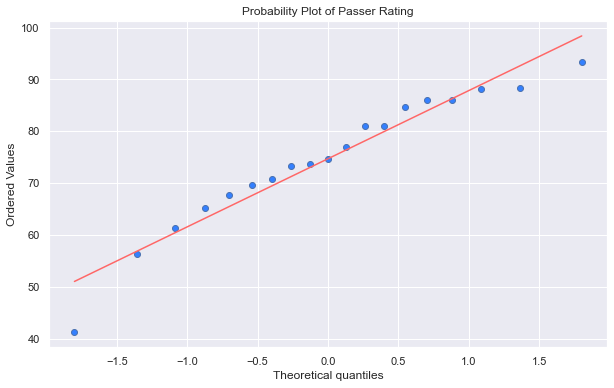

In [30]:
probplot_by_var(case_prev, 'Rate')

And all of our QBs:

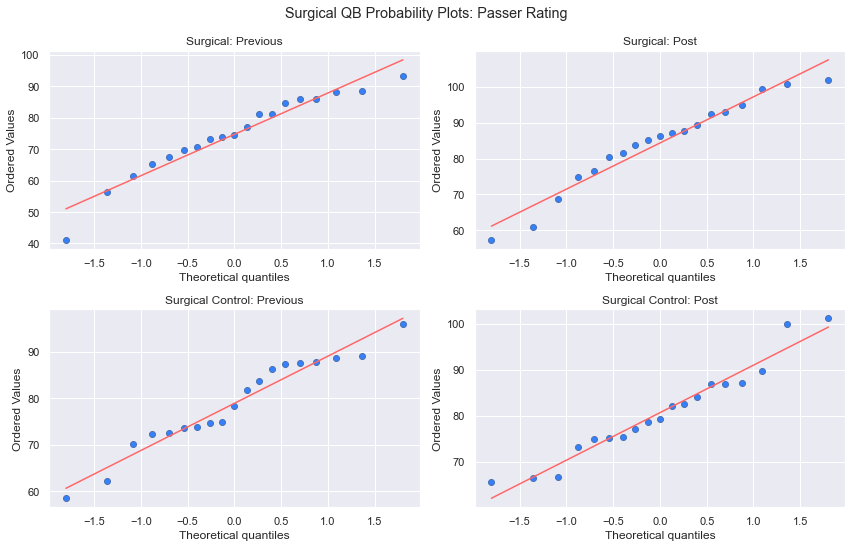

In [31]:
cohorts = [case_prev, case_post, ctrl_prev, ctrl_post]
cohort_names = ['Surgical: Previous', 'Surgical: Post', 'Surgical Control: Previous', 'Surgical Control: Post']
fig = plt.figure(figsize=(12,8))
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    stats.probplot(cohorts[i]['Rate'], plot=plt)
    ax.get_lines()[0].set_markerfacecolor(blue)
    ax.get_lines()[1].set_color(red)
    ax.set_title(cohort_names[i])
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Surgical QB Probability Plots: Passer Rating')
plt.show()

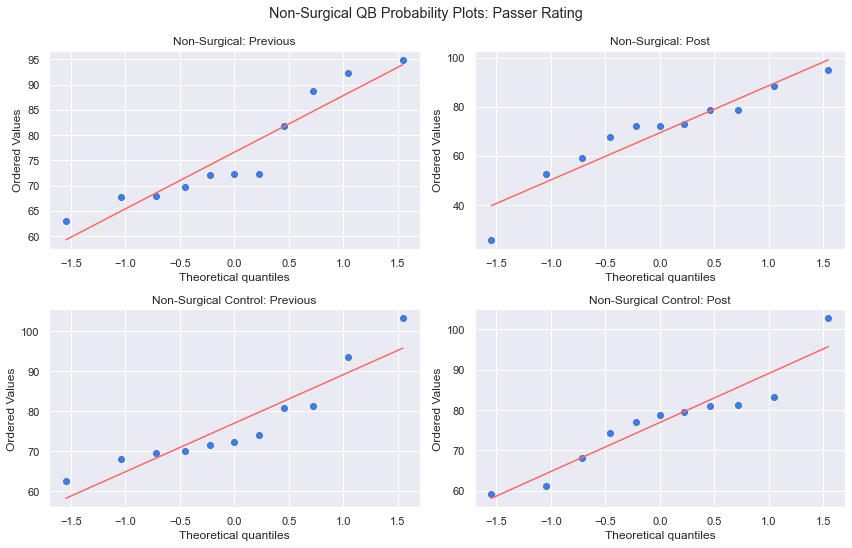

In [32]:
cohorts = [inj_prev, inj_post, inj_ctrl_prev, inj_ctrl_post]
cohort_names = ['Non-Surgical: Previous', 'Non-Surgical: Post', 'Non-Surgical Control: Previous', 'Non-Surgical Control: Post']
fig = plt.figure(figsize=(12,8))
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    stats.probplot(cohorts[i]['Rate'], plot=plt)
    ax.get_lines()[0].set_markerfacecolor(blue)
    ax.get_lines()[1].set_color(red)
    ax.set_title(cohort_names[i])
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Non-Surgical QB Probability Plots: Passer Rating')
plt.show()

## Shapiro-Wilk Test for Normality

In [33]:
stat, p = shapiro(all_qb_stats['Rate'])
print('Stat: '+str(stat)+'   p-value: '+str(p))

Stat: 0.9963261485099792   p-value: 0.7873727679252625


In [34]:
stat, p = shapiro(inj_prev['AY/A'])
print('Stat: '+str(stat)+'   p-value: '+str(p))

Stat: 0.9435199499130249   p-value: 0.562719464302063


## QB Performance Statistics

Now lets take a closer look at the performance statistics of QBs. We are looking at passing statistics that are consistently recorded for all of our QBs going back to 1980, these are: Passer Rating (Rate), Completion Percentage (Cmp%), Passing Yards (Yds), Completions (Cmp), Attempts (Att), Yards per Pass Attempt (Y/A), Adjusted Yards per Pass Attempt (AY/A), Passing Touchdowns (TD), Interceptions (Int), Sacks (Sk), and Yards Lost to Sacks (Yds.1). 

<br>

Passer Rating and Adjusted Yards per Attempt are calculations of several aggregated statistics. 

Passer Rating is calculated as follows:

(a + b + c + d) / 6 * 100

where

a = (CMP/ATT - 0.3) * 5

b = (YDS/ATT - 3) * 0.25

c = (TD/ATT) * 20

d = 2.375 - (INT/ATT * 25)

<br>

Adjusted Yards per Pass Attempt is calculated as follows:

AY/A = (YDS + 20 * TD - 45 * INT) / ATT

We can find an easier way to look at a QB's statistics than numbers on a chart, with a radial plot. Since statistics have very different ranges though, such as passing yards in the hundreds and interceptions per game less than 5, we have to look at these as percentages. Let's calculate a QB's statistics as a percentage of the population average. 

In [35]:
def get_player_percent(player, df, all_qbs):
    res = df[df['Name']==player]
    res.set_index('Name', drop=True, inplace=True)
    res.drop(columns=['Age', 'Games'], inplace=True)
    res = res[['Rate', 'Cmp%', 'Yds', 'Cmp', 'Att', 'Y/A', 'AY/A', 'TD', 'Int', 'Sk', 'Yds.1']]
    for var in res.columns:
        avgvar = all_qbs[var].mean()
        res[var] = res[var]/avgvar
    return res

In [36]:
smith_prev = get_player_percent('Alex Smith', case_prev, all_qb_stats)
smith_post = get_player_percent('Alex Smith', case_post, all_qb_stats)
smith_prev

c:\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Rate,Cmp%,Yds,Cmp,Att,Y/A,AY/A,TD,Int,Sk,Yds.1
Name,,,,,,,,,,,
Alex Smith,0.848928,0.970117,0.848582,0.922007,0.980547,0.882464,0.787074,0.603743,1.128319,1.263911,1.160729


Lets plot Alex Smith's statistics before and after his surgery, as a percentage of the average NFL QB statistics.

In [37]:
def radar_plot(df1, df2, df3=None, df4=None, prevpost=False, max_val=1.5):    
    label1 = df1.index[0]+' (Previous)' if prevpost else df1.index[0]
    label2 = df2.index[0]+' (Post)' if prevpost else df2.index[0]
    if df3 is not None and df4 is not None:
        plt.figure(figsize=(18,18))
        ax = plt.subplot(121, polar=True)
    else: 
        plt.figure(figsize=(14,8))
        ax = plt.subplot(111, polar=True)
        plt.title('{} vs {}: % of NFL Average'.format(label1, label2))

    categories=list(df1)
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    plt.xticks(angles[:-1], categories, color='black', size=12)
    ax.set_rlabel_position(0)
    yticks = [max_val*i/6 for i in range(1,6)]
    plt.yticks(yticks, [str(e) for e in yticks], color='grey', size=14)
    plt.ylim(0,max_val)
    colors = ['blue','red']
    
    values1 = df1.values.flatten().tolist()
    values1 += values1[:1]
    ax.plot(angles, values1, linewidth=1, linestyle='solid', color=colors[0], label=label1)
    ax.fill(angles, values1, color=colors[0], alpha=0.1)
    values2 = df2.values.flatten().tolist()
    values2 += values2[:1]
    ax.plot(angles, values2, linewidth=1, linestyle='solid', color=colors[1], label=label2)
    ax.fill(angles, values2, color=colors[1], alpha=0.1)
    plt.legend(loc=0, bbox_to_anchor=(0.1, 0.1), prop={'size': 13})
    
    if df3 is not None and df4 is not None:
        plt.title('{} vs {}: Previous, % of NFL Average'.format(label1, label2))
        ax = plt.subplot(122, polar=True)
        plt.xticks(angles[:-1], categories, color='black', size=12)
        ax.set_rlabel_position(0)
        yticks = [max_val*i/6 for i in range(1,6)]
        plt.yticks(yticks, [str(e) for e in yticks], color='grey', size=14)
        plt.ylim(0,max_val)
        values1 = df3.values.flatten().tolist()
        values1 += values1[:1]
        ax.plot(angles, values1, linewidth=1, linestyle='solid', color=colors[0], label=df3.index[0])
        ax.fill(angles, values1, color=colors[0], alpha=0.1)
        values2 = df4.values.flatten().tolist()
        values2 += values2[:1]
        ax.plot(angles, values2, linewidth=1, linestyle='solid', color=colors[1], label=df4.index[0])
        ax.fill(angles, values2, color=colors[1], alpha=0.1)
        plt.legend(loc=0, bbox_to_anchor=(0.1, 0.1), prop={'size': 13})
        plt.title('{} vs {}: Post, % of NFL Average'.format(df3.index[0], df4.index[0]))
    plt.show()

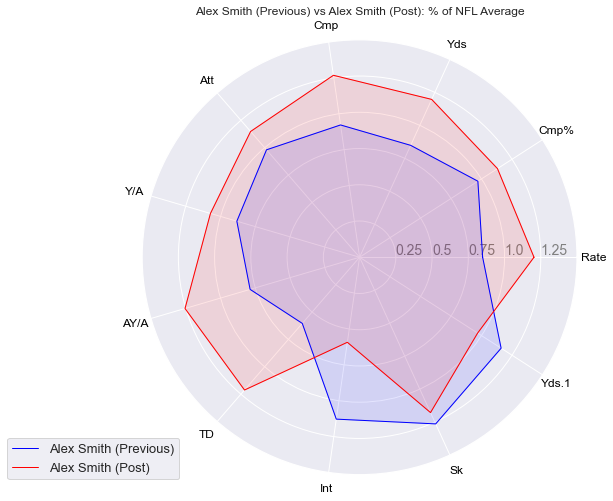

In [38]:
radar_plot(smith_prev, smith_post, prevpost=True)

Or we can compare two different QBs:

In [39]:
vick_prev = get_player_percent('Michael Vick', ctrl_prev, all_qb_stats)

c:\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


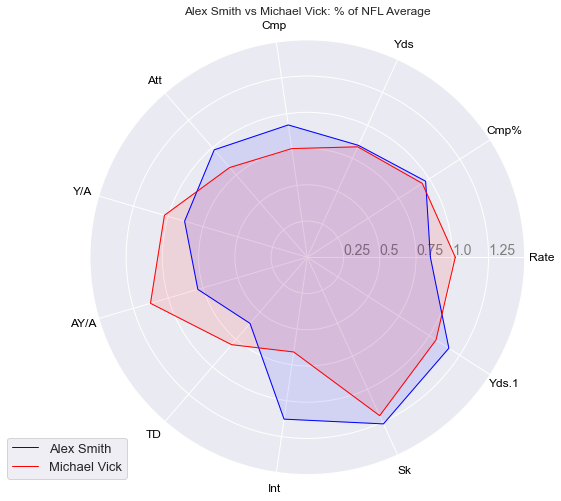

In [40]:
radar_plot(smith_prev, vick_prev)

And now lets look at Alex Smith and his control, Michael Vick, for their previous and post surgery/index performances.

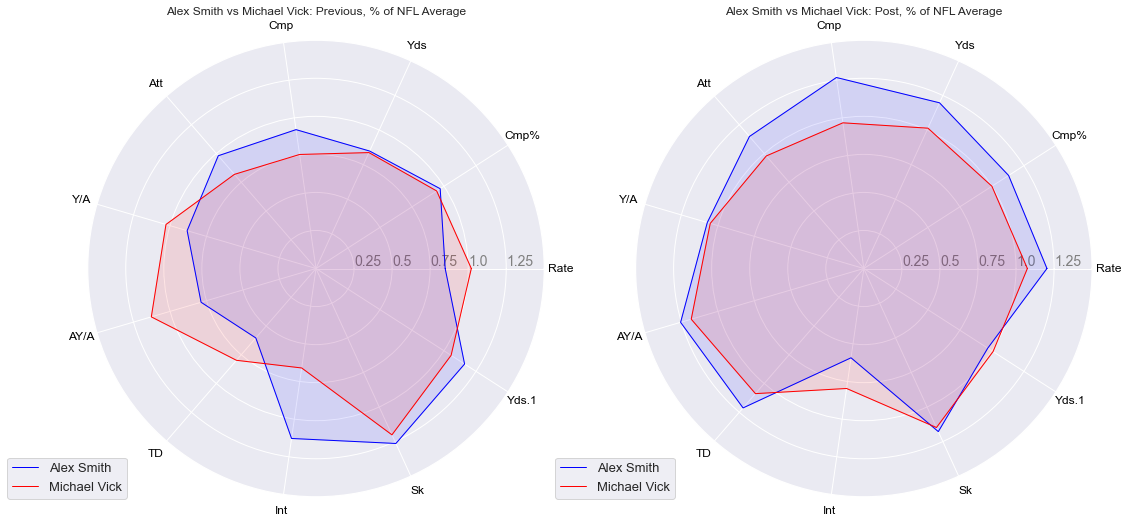

In [41]:
vick_post = get_player_percent('Michael Vick', ctrl_post, all_qb_stats)
radar_plot(smith_prev, vick_prev, smith_post, vick_post)

## Case QBs Pre and Post Surgery

The next step is to examine the performance statistics of our case QBs before and after their surgeries. We can look at the cohort as a whole. 

In [42]:
def plot_pre_post(case_prev, case_post, var):
    var_conv = {'Rate': 9, 'Games': 1, 'Cmp': 3, 'Att': 4, 'Cmp%': 5, 'Yds': 6, 'TD': 7, 'Int': 8, 'Sk': 10, 'Yds.1': 11, 'Y/A': 12, 'AY/A': 13}
    var_name = var
    var = var_conv[var]
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,6))
    for i in range(len(case_prev)):
        ax1.scatter(i/36, case_prev.iloc[i,var], color=blue, alpha=0.75)
        ax1.scatter(1+i/36, case_post.iloc[i,var], color=red, alpha=0.75)
    ax1.plot([0,0.5], [case_prev.iloc[:,var].mean(), case_prev.iloc[:,var].mean()], color=blue, linewidth=3)
    ax1.plot([1,1.5], [case_post.iloc[:,var].mean(), case_post.iloc[:,var].mean()], color=red, linewidth=3)
    
    ax1.set_xlim(-0.5,2)
    ax1.set_xticks([.25,1.25])
    ax1.set_xticklabels(['Previous', 'Post'])
    ax1.set_ylabel(stat_names[var_name])

    for i in range(len(case_prev)):
        ax2.scatter(1, case_prev.iloc[i,var], color=blue, alpha=0.75)
        ax2.scatter(2, case_post.iloc[i,var], color=red, alpha=0.75)
        if case_post.iloc[i,var] - case_prev.iloc[i,var] > 0:
            c = 'green'
        else:
            c = 'red'
        ax2.plot([1, 2], [case_prev.iloc[i,var], case_post.iloc[i,var]], color=c, linewidth=0.5, alpha=0.5)
    ax2.set_xlim(0.5,2.5)
    ax2.set_xticks([1,2])
    ax2.set_xticklabels(['Previous', 'Post'])

    return ax1, ax2

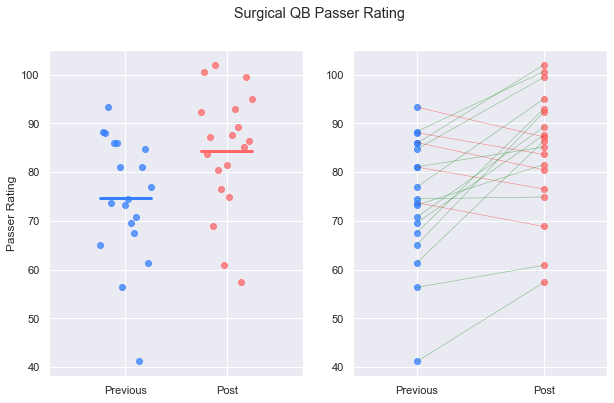

In [43]:
plot_pre_post(case_prev, case_post, 'Rate')
plt.suptitle('Surgical QB Passer Rating')
plt.show()

And their controls:

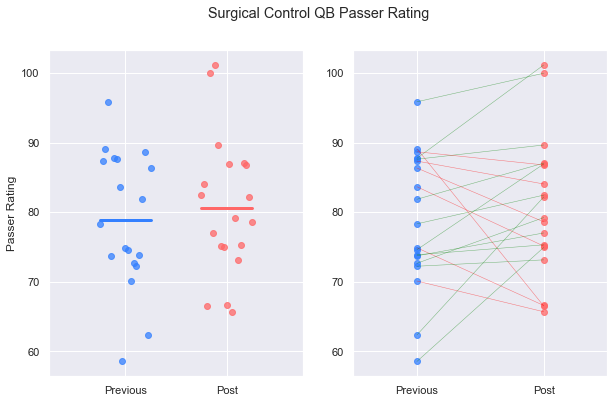

In [44]:
plot_pre_post(ctrl_prev, ctrl_post, 'Rate')
plt.suptitle('Surgical Control QB Passer Rating')
plt.show()

Compare that with the decline in performance seen in quarterbacks who did not have surgical intervention.

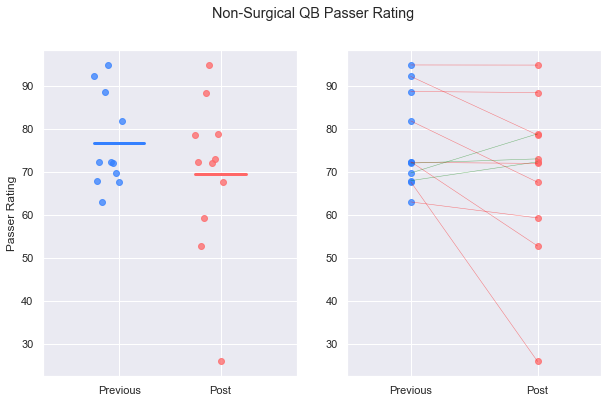

In [45]:
plot_pre_post(inj_prev, inj_post, 'Rate')
plt.suptitle('Non-Surgical QB Passer Rating')
plt.show()

Non-surgical quarterback controls maintained their average performance over the same timespan. 

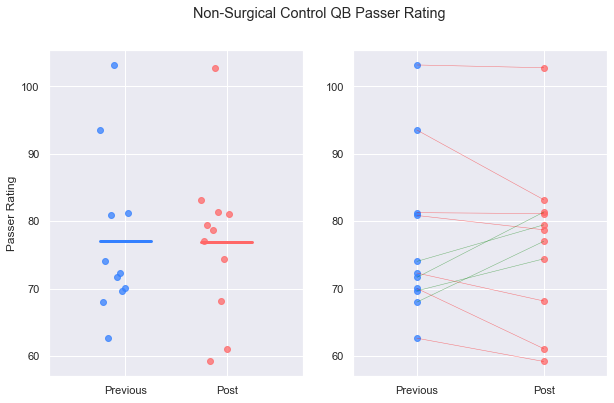

In [46]:
plot_pre_post(inj_ctrl_prev, inj_ctrl_post, 'Rate')
plt.suptitle('Non-Surgical Control QB Passer Rating')
plt.show()

Plotting the groups on the same graph helps make comparisons.

In [47]:
def plot_case_control(case_prev, case_post, ctrl_prev, ctrl_post, var):
    var_conv = {'Rate': 9, 'Games': 1, 'Cmp': 3, 'Att': 4, 'Cmp%': 5, 'Yds': 6, 'TD': 7, 'Int': 8, 'Sk': 10, 'Yds.1': 11, 'Y/A': 12, 'AY/A': 13}
    var_name = var
    var = var_conv[var]
    length = len(case_prev)
    fig, ax = plt.subplots(figsize=(10,6))
    if len(case_prev)!=len(ctrl_prev):
        for i in range(len(case_prev)):
            ax.scatter(1.5+i/length, case_prev.iloc[i,var], color=red, alpha=0.75)
            ax.scatter(6+i/length, case_post.iloc[i,var], color=red, marker='^', alpha=0.75)
        for j in range(len(ctrl_prev)):
            ax.scatter(3+j/length, ctrl_prev.iloc[j,var], color=blue, alpha=0.75)
            ax.scatter(7.5+j/length, ctrl_post.iloc[j,var], color=blue, marker='^', alpha=0.75)
    else:
        for i in range(len(case_prev)):
            ax.scatter(1.5+i/length, case_prev.iloc[i,var], color=red, alpha=0.75)
            ax.scatter(3+i/length, ctrl_prev.iloc[i,var], color=blue, alpha=0.75)
            ax.scatter(6+i/length, case_post.iloc[i,var], color=red, marker='^', alpha=0.75)
            ax.scatter(7.5+i/length, ctrl_post.iloc[i,var], color=blue, marker='^', alpha=0.75)
    ax.plot([1.5,2.5], [case_prev.iloc[:,var].mean(), case_prev.iloc[:,var].mean()], color=red, linewidth=3)
    ax.plot([3,4], [ctrl_prev.iloc[:,var].mean(), ctrl_prev.iloc[:,var].mean()], color=blue, linewidth=3)
    ax.plot([6,7], [case_post.iloc[:,var].mean(), case_post.iloc[:,var].mean()], color=red, linestyle=':',linewidth=3)
    ax.plot([7.5,8.5], [ctrl_post.iloc[:,var].mean(), ctrl_post.iloc[:,var].mean()], color=blue, linestyle=':',linewidth=3)
    ax.set_xlim(0,10)
    ax.set_xticks([2.75, 7.25])
    ax.set_xticklabels(['Previous', 'Post'])
    ax.set_ylabel('{}'.format(stat_names[var_name]))
    return ax

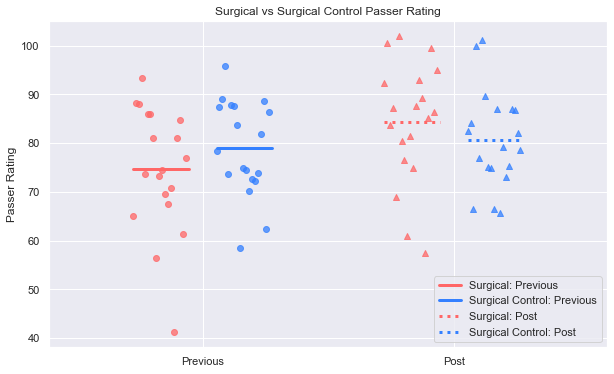

In [48]:
plot_case_control(case_prev, case_post, ctrl_prev, ctrl_post, 'Rate')
plt.title('Surgical vs Surgical Control Passer Rating')
plt.legend(['Surgical: Previous', 'Surgical Control: Previous', 'Surgical: Post', 'Surgical Control: Post'])
plt.show()

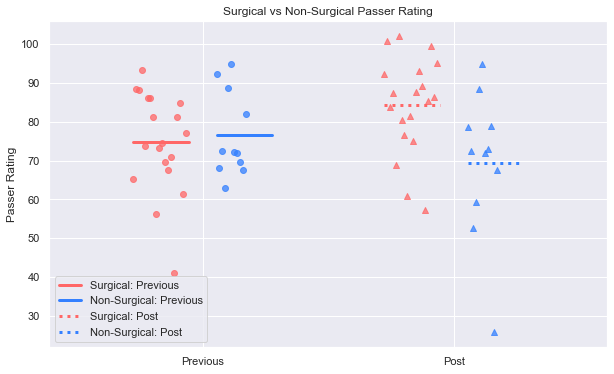

In [49]:
plot_case_control(case_prev, case_post, inj_prev, inj_post, 'Rate')
plt.title('Surgical vs Non-Surgical Passer Rating')
plt.legend(['Surgical: Previous', 'Non-Surgical: Previous', 'Surgical: Post', 'Non-Surgical: Post'])
plt.show()

They can also be visualized on the same scale but with each cohort grouped to better understand the chart. 

In [50]:
def plot_pre_post_two_cohorts(case_prev, case_post, ctrl_prev, ctrl_post, var):
    var_conv = {'Rate': 9, 'Games': 1, 'Cmp': 3, 'Att': 4, 'Cmp%': 5, 'Yds': 6, 'TD': 7, 'Int': 8, 'Sk': 10, 'Yds.1': 11, 'Y/A': 12, 'AY/A': 13}
    var_name = var
    var = var_conv[var]
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,6))
    for i in range(len(case_prev)):
        ax1.scatter(i/36, case_prev.iloc[i,var], color=blue, alpha=0.75)
        ax1.scatter(1+i/36, case_post.iloc[i,var], color=red, alpha=0.75)
    ax1.plot([0,0.5], [case_prev.iloc[:,var].mean(), case_prev.iloc[:,var].mean()], color=blue, linewidth=3)
    ax1.plot([1,1.5], [case_post.iloc[:,var].mean(), case_post.iloc[:,var].mean()], color=red, linewidth=3)
    
    ax1.set_xlim(-0.5,2)
    ax1.set_ylim(20,110)
    ax1.set_xticks([.25,1.25])
    ax1.set_xticklabels(['Previous', 'Post'])
    ax1.set_ylabel(stat_names[var_name])

    for i in range(len(ctrl_prev)):
        ax2.scatter(i/36, ctrl_prev.iloc[i,var], color=blue, alpha=0.75)
        ax2.scatter(1+i/36, ctrl_post.iloc[i,var], color=red, alpha=0.75)
    ax2.plot([0,0.5], [ctrl_prev.iloc[:,var].mean(), ctrl_prev.iloc[:,var].mean()], color=blue, linewidth=3)
    ax2.plot([1,1.5], [ctrl_post.iloc[:,var].mean(), ctrl_post.iloc[:,var].mean()], color=red, linewidth=3)
    
    ax2.set_xlim(-0.5,2)
    ax2.set_ylim(20,110)
    ax2.set_xticks([.25,1.25])
    ax2.set_xticklabels(['Previous', 'Post'])

    return ax1, ax2

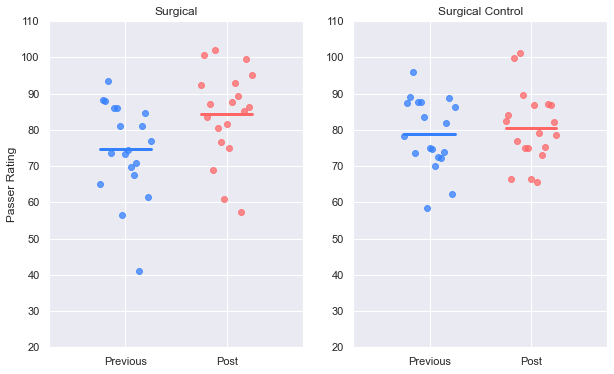

In [51]:
ax1, ax2 = plot_pre_post_two_cohorts(case_prev, case_post, ctrl_prev, ctrl_post, 'Rate')
ax1.set_title('Surgical')
ax2.set_title('Surgical Control')
plt.show()

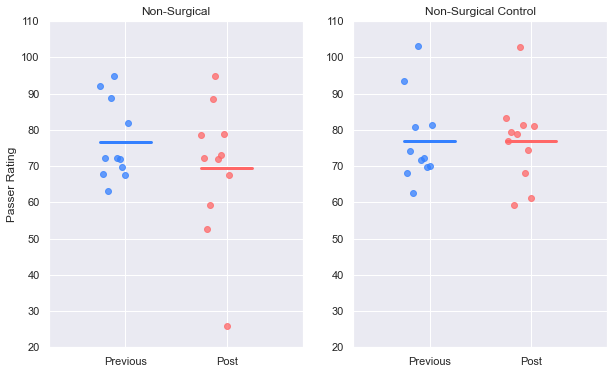

In [52]:
ax1, ax2 = plot_pre_post_two_cohorts(inj_prev, inj_post, inj_ctrl_prev, inj_ctrl_post, 'Rate')
ax1.set_title('Non-Surgical')
ax2.set_title('Non-Surgical Control')
plt.show()

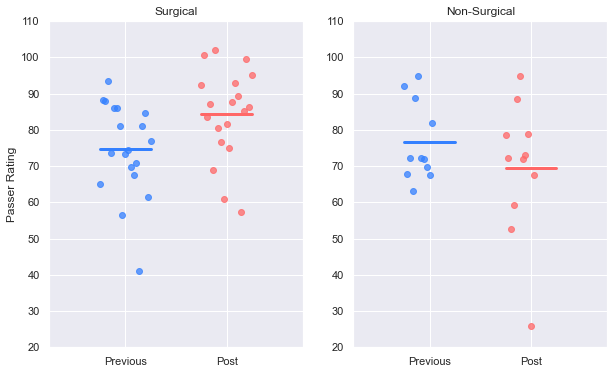

In [53]:
ax1, ax2 = plot_pre_post_two_cohorts(case_prev, case_post, inj_prev, inj_post, 'Rate')
ax1.set_title('Surgical')
ax2.set_title('Non-Surgical')
plt.show()

## Statistical Analysis

We can output statistics by comparing cohorts using t-tests to identify statistically significant changes. The limiting factor of this data exploration is the small sample sizes. The NFL has very few quarterbacks playing substantial amounts of games at any given time, and fewer suffer serious shoulder injuries. Small sample sizes mean any comparison may not be appropriately powered to draw meaningful conclusions, so performing t-tests on individual statistics between cohorts should let us know if those conclusions are statistically significant. 

In [84]:
def ttest_ind_gsa(case_prev, case_post, ctrl_prev, ctrl_post, var):
    n = len(case_prev)
    case_diff = case_post[var]-case_prev[var]
    ctrl_diff = ctrl_post[var]-ctrl_prev[var]
    diff = case_diff.mean()-ctrl_diff.mean()
    sign = '+' if diff>0 else ''
    ttest = stats.ttest_ind(case_diff, ctrl_diff);
    print(var+' %1.6f'%ttest[1])
    print('Case: %1.4f'%case_diff.mean()+'    Control: %1.4f'%ctrl_diff.mean()+'    Gain Score: '+sign+'%1.4f'%diff)
    print('   n: %1d'%n+'        t-value: %1.4f'%ttest[0]+'       p-value: %1.6f'%ttest[1])
    return(case_diff.mean()-ctrl_diff.mean(), ttest[1])

def ttest_rel_by_var(prev, post, var):
    n = len(prev)
    prev_mean = prev[var].mean()
    post_mean = post[var].mean()
    diff = post_mean-prev_mean
    sign='+' if diff>0 else ''
    ttest = stats.ttest_rel(prev[var], post[var])
    print(var+' %1.6f'%ttest[1])
    print('Previous: %1.4f'%prev_mean+'    Post: %1.4f'%post_mean+'    Difference: '+sign+'%1.4f'%diff)
    print('       n: %1d'%n+'      t-value: %1.4f'%ttest[0]+'       p-value: %1.4f'%ttest[1])
    return diff, ttest[1]

def ttest_ind_by_var(case, ctrl, var):
    n = len(case)
    case_mean = case[var].mean()
    ctrl_mean = ctrl[var].mean()
    diff = case_mean-ctrl_mean
    sign = '+' if diff>0 else ''
    ttest = stats.ttest_ind(case[var], ctrl[var])
    print(var+' %1.6f'%ttest[1])
    print('Case: %1.4f'%case_mean+'    Control: %1.4f'%ctrl_mean+'    Difference: '+sign+'%1.4f'%diff)
    print('   n: %1d'%n+'         t-value: %1.4f'%ttest[0]+'       p-value: %1.4f'%ttest[1])
    return diff, ttest[1]

def pooled_standard_deviation(sample1,sample2):
    n1, n2 = len(sample1), len(sample2)
    var1, var2 = np.var(sample1, ddof=1), np.var(sample2, ddof=1)
    numerator = ((n1-1) * var1) + ((n2-1) * var2)
    denominator = n1+n2-2
    return np.sqrt(numerator/denominator)

def Cohens_d(sample1, sample2):
    u1, u2 = np.mean(sample1), np.mean(sample2)
    s_pooled = pooled_standard_deviation(sample1, sample2)
    return ((u1 - u2) / s_pooled)

def calc_power(case_prev, case_post, ctrl_prev, ctrl_post, var='Rate', alpha=0.05, ratio=1):
    case_diff = case_post[var]-case_prev[var]
    ctrl_diff = ctrl_post[var]-ctrl_prev[var]
    effect_size = Cohens_d(case_diff, ctrl_diff)
    analysis = TTestIndPower()
    power = analysis.solve_power(effect_size, power=None, nobs1=len(case_diff), ratio=ratio, alpha=alpha)
    return power

var_list = ['Rate', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Sk', 'Yds.1', 'Y/A', 'AY/A']

We can use a paired t-test to examine the effects of a shoulder injury and subsequent surgical or non-surgical intervention, since we are looking at the same related group at 2 different time points. 

In [86]:
for var in var_list:
    d, t = ttest_rel_by_var(ctrl_prev, ctrl_post, var)
    # print(var, '%0.6f'%t)

Rate 0.461702
Previous: 78.9109    Post: 80.6392    Difference: +1.7282
       n: 19      t-value: -0.7521       p-value: 0.4617
Cmp 0.916577
Previous: 16.7589    Post: 16.6298    Difference: -0.1292
       n: 19      t-value: 0.1062       p-value: 0.9166
Att 0.599649
Previous: 28.7980    Post: 27.7740    Difference: -1.0240
       n: 19      t-value: 0.5343       p-value: 0.5996
Cmp% 0.768927
Previous: 57.5311    Post: 57.9723    Difference: +0.4411
       n: 19      t-value: -0.2983       p-value: 0.7689
Yds 0.727577
Previous: 198.5172    Post: 193.2015    Difference: -5.3158
       n: 19      t-value: 0.3538       p-value: 0.7276
TD 0.698892
Previous: 1.2078    Post: 1.1704    Difference: -0.0374
       n: 19      t-value: 0.3931       p-value: 0.6989
Int 0.727993
Previous: 0.9671    Post: 0.9202    Difference: -0.0469
       n: 19      t-value: 0.3533       p-value: 0.7280
Sk 0.439128
Previous: 2.0988    Post: 1.9381    Difference: -0.1607
       n: 19      t-value: 0.7912       p-

For example, we can see the p-values for each performance statistic we are looking at. For the case control quarterbacks, it looks like none of the values range from ~0.41 to ~0.92, which are well above the chosen threshold of 0.05 to achieve statistical significance. However, given that none of these quarterbacks suffered an injury, their respective timepoints are arbitrary and so their previous and post performances understandably do not show a correlation. 

Now we can run the same t-test comparison on the case quarterbacks who DID have surgery:

In [87]:

for var in var_list:
    d, t = ttest_rel_by_var(case_prev, case_post, var)
    # print(var, '%0.6f'%t)

Rate 0.001764
Previous: 74.7038    Post: 84.3321    Difference: +9.6283
       n: 19      t-value: -3.6670       p-value: 0.0018
Cmp 0.000914
Previous: 16.1113    Post: 18.7180    Difference: +2.6067
       n: 19      t-value: -3.9620       p-value: 0.0009
Att 0.042101
Previous: 27.9853    Post: 29.8854    Difference: +1.9000
       n: 19      t-value: -2.1880       p-value: 0.0421
Cmp% 0.000009
Previous: 56.6555    Post: 61.5307    Difference: +4.8753
       n: 19      t-value: -6.0958       p-value: 0.0000
Yds 0.029363
Previous: 185.4761    Post: 207.8934    Difference: +22.4174
       n: 19      t-value: -2.3667       p-value: 0.0294
TD 0.019184
Previous: 1.0627    Post: 1.2850    Difference: +0.2222
       n: 19      t-value: -2.5723       p-value: 0.0192
Int 0.009196
Previous: 1.0079    Post: 0.8136    Difference: -0.1943
       n: 19      t-value: 2.9173       p-value: 0.0092
Sk 0.314115
Previous: 2.1218    Post: 1.9864    Difference: -0.1354
       n: 19      t-value: 1.0356    

Now we can see the p-values for the case group are much lower, and are under the 0.05 threshold for achieving statistical significance for the following: Passer Rating, Completions, Pass Attempts, Completion Percentage, Passing Yards, Touchdowns, Interceptions, Yards Lost to Sacks, and Adjusted Yards per Pass Attempt.

Next, rather than comparing one group at 2 timepoints, or 2 groups together at the same timepoint, we can attempt to compare the *change* in performance between groups. We can do so using a Gain Score Analysis, which takes the gain over the timepoint, or how much a group improved or declined, and compare that with the gain of another group. Here we can compare the *change* in performance for our case quarterbacks after surgery vs the *change* in performance of our control quarterbacks who were not injured. 

In [88]:
for var in var_list:
    ttest_ind_gsa(case_prev, case_post, ctrl_prev, ctrl_post, var)

Rate 0.029685
Case: 9.6283    Control: 1.7282    Gain Score: +7.9000
   n: 19        t-value: 2.2642       p-value: 0.029685
Cmp 0.055496
Case: 2.6067    Control: -0.1292    Gain Score: +2.7359
   n: 19        t-value: 1.9791       p-value: 0.055496
Att 0.173131
Case: 1.9000    Control: -1.0240    Gain Score: +2.9240
   n: 19        t-value: 1.3898       p-value: 0.173131
Cmp% 0.012268
Case: 4.8753    Control: 0.4411    Gain Score: +4.4341
   n: 19        t-value: 2.6371       p-value: 0.012268
Yds 0.127148
Case: 22.4174    Control: -5.3158    Gain Score: +27.7331
   n: 19        t-value: 1.5615       p-value: 0.127148
TD 0.050775
Case: 0.2222    Control: -0.0374    Gain Score: +0.2596
   n: 19        t-value: 2.0209       p-value: 0.050775
Int 0.327672
Case: -0.1943    Control: -0.0469    Gain Score: -0.1474
   n: 19        t-value: -0.9923       p-value: 0.327672
Sk 0.917193
Case: -0.1354    Control: -0.1607    Gain Score: +0.0253
   n: 19        t-value: 0.1047       p-value: 0.9171

We can also compare the *change* in quarterbacks who were injured and had surgery, vs those who were injured and did NOT have surgery:

In [89]:
for var in var_list:
    ttest_ind_gsa(case_prev, case_post, inj_prev, inj_post, var)

Rate 0.001462
Case: 9.6283    Control: -7.1938    Gain Score: +16.8221
   n: 19        t-value: 3.5289       p-value: 0.001462
Cmp 0.006175
Case: 2.6067    Control: -1.4288    Gain Score: +4.0355
   n: 19        t-value: 2.9616       p-value: 0.006175
Att 0.061708
Case: 1.9000    Control: -2.0222    Gain Score: +3.9223
   n: 19        t-value: 1.9464       p-value: 0.061708
Cmp% 0.000669
Case: 4.8753    Control: -3.3497    Gain Score: +8.2249
   n: 19        t-value: 3.8256       p-value: 0.000669
Yds 0.012728
Case: 22.4174    Control: -23.1322    Gain Score: +45.5496
   n: 19        t-value: 2.6618       p-value: 0.012728
TD 0.032769
Case: 0.2222    Control: -0.1478    Gain Score: +0.3700
   n: 19        t-value: 2.2461       p-value: 0.032769
Int 0.361604
Case: -0.1943    Control: -0.0727    Gain Score: -0.1217
   n: 19        t-value: -0.9275       p-value: 0.361604
Sk 0.726291
Case: -0.1354    Control: -0.2408    Gain Score: +0.1054
   n: 19        t-value: 0.3536       p-value: 0.

We can see that there is a statistically significant difference in Passer Rating, Completions, Completion Percentage, Passing Yards, Touchdowns, Yards per Pass Attempt, and Adjusted Yards per Pass Attempt. This indicates there is a potential positive effect on quarterbacks who have surgical intervention following a shoulder injury vs those who are treated non-surgically. 

In [71]:
calc_power(case_prev, case_post, ctrl_prev, ctrl_post)

0.5962222319545054

We can also calculate the power of this study. Statistical power is ideally greater than 0.80 for robust studies, but in small sample size studies it decreases. With a small sample size of NFL quarterbacks, it is expectedly underpowered, but it still allows for conclusions to be drawn. Comparing the case and control groups show the power of this t-test would be 0.5962. Comparable articles in the sports science literature have to use small sample sizes, for example Busfield et al. (https://www.arthroscopyjournal.org/article/S0749-8063(09)00193-5/fulltext).

## Conclusion

Despite small sample sizes, detailed performance metrics of NFL quarterbacks have allowed use to analyze performances with regards to shoulder injury and surgery. We can draw preliminary conclusions from the data that quarterbacks who suffer severe shoulder injuries who are treated surgically, tend to have statistically significant improvements in performances upon their return, when compared to their prior performance, and the performance of quarterbacks who were similarly injured but treated non-surgically. 

Further research may include examining greater sample sizes such as collegiate football quarterbacks, a wider range of performance metrics such as pass lengths, and stratification of cohorts based on specific shoulder injury. 

There are many limitations to this exploratory analysis. Primarily, the sample size is small, and therefore the power of these statistical tests is smaller. This means that the effects of surgical and non-surgical intervention on quarterback performance should be looked into further, as the data is tending towards surgical intervention improving outcomes but at a very low sample size. 

Further, there are numerous outside factors not considered here. Quarterback performances tend to improve with age up to a certain point, as players become more experienced. This could have confounding factors, such as quarterbacks who play more games getting injured more often, better quarterbacks being medically treated differently from other quarterbacks, quarterbacks retiring towards their peaks, etc. 

There are also only a few selected statistics used to draw conclusions here, which will no doubt increase in the future as tracking these performance metrics becomes more common and detailed. There will be opportunities in the future to take advantage of these metrics, or even increase the sample size by looking at college football for example. 

The data outputted from this exploratory data analysis has been used in the posters and pre-papers of "Performance Following Surgical and Non-surgical
Management of Shoulder Injury in NFL Quarterbacks" by Frederick Durrant B.S., George Durrant M.Eng., Martinus Megalla B.A., Teja Makkapati B.A., Nareena Imam B.A., Rocco Bassora M.D., and Frank Alberta M.D., in conjunction with Hackensack Meridian School of Medicine and the Rothman Orthopedic Institute. 

## Appendix

Assorted graphs indicating NFL QB performance over time vs controls of the population of all NFL QBs in the dataset.

In [100]:
%matplotlib inline
sns.set()
red = (255/255,103/255,103/255)
# red = (.9, 0.4, 0.4)
blue = (52/255,128/255,255/255, 1)
# red = np.array([.9, .4, .4])
blue = np.array([.2, .4, .9])
red = np.array(red)

In [101]:
def plot_case_control_by_year(cases, controls, var):
    plt.figure(figsize=(12,76))
    for i, row in cases.iterrows():
        plt.subplot(len(cases),1,i+1)
        ctrl = controls[row.Name]
        case_stats = get_qb_yearly_stats(row.Name)
        ctrl_stats = get_qb_yearly_stats(ctrl)
        case_prev = case_stats[case_stats['Age'] < row.SurgeryAge]
        case_post = case_stats[case_stats['Age'] > row.SurgeryAge]
        ctrl_prev = ctrl_stats[ctrl_stats['Age'] < row.SurgeryAge]
        ctrl_post = ctrl_stats[ctrl_stats['Age'] > row.SurgeryAge]
        labels= ['Case: Previous', 'Case: Post', 'Control: Previous', 'Control: Post', 'Surgery']

        print(case_prev.Age.shape)

        plt.scatter(case_prev.Age, case_prev['{}'.format(var)], c=red)
        plt.plot(case_prev.Age, case_prev['{}'.format(var)], c=red, linewidth=0.5)
        plt.scatter(case_post.Age, case_post['{}'.format(var)], c=red, marker='^')
        plt.plot(case_post.Age, case_post['{}'.format(var)], c=red, linestyle='-.', linewidth=1)
        plt.scatter(ctrl_prev.Age, ctrl_prev['{}'.format(var)], c=blue)
        plt.plot(ctrl_prev.Age, ctrl_prev['{}'.format(var)], c=blue, linewidth=0.5)
        plt.scatter(ctrl_post.Age, ctrl_post['{}'.format(var)], c=blue, marker='^')
        plt.plot(ctrl_post.Age, ctrl_post['{}'.format(var)], c=blue, linestyle='-.', linewidth=1)
        plt.axvline(x=row.SurgeryAge, color='green') 
        plt.plot([ctrl_prev.Age.values[-1],ctrl_post.Age.values[0]], [ctrl_prev['{}'.format(var)].values[-1],ctrl_post['{}'.format(var)].values[0]], color=blue, linestyle='-.',linewidth=0.5)
        plt.legend(labels, fontsize='medium', loc='lower right')
        plt.title('Case: {} vs Control: {}, for {} over Age'.format(row.Name, ctrl, var))
        plt.ylabel('{}'.format(var))
        plt.xlabel('Age')
    plt.tight_layout()
    plt.show()

def plot_case_pop_by_year(cases, all_controls, var):
    plt.figure(figsize=(12,76))
    for i, row in cases.iterrows():
        plt.subplot(len(cases),1,i+1)
        case_stats = get_qb_yearly_stats(row.Name)
        ctrl_stats = all_controls
        firstage = case_stats.iloc[0, 0]
        lastage = case_stats.iloc[-1, 0]
        case_prev = case_stats[case_stats['Age'] < row.SurgeryAge]
        case_post = case_stats[case_stats['Age'] > row.SurgeryAge]
        ctrl_prev = ctrl_stats[(ctrl_stats['Age'] < row.SurgeryAge) & (ctrl_stats['Age'] > firstage-1)]
        ctrl_post = ctrl_stats[(ctrl_stats['Age'] > row.SurgeryAge) & (ctrl_stats['Age'] < lastage+1)]
        labels= ['Case: Previous', 'Case: Post', 'Control: Previous', 'Control: Post', 'Surgery']

        plt.scatter(case_prev.Age, case_prev['{}'.format(var)], color=red)
        plt.plot(case_prev.Age, case_prev['{}'.format(var)], color=red, linewidth=0.5)
        plt.scatter(case_post.Age, case_post['{}'.format(var)], color=red, marker='^')
        plt.plot(case_post.Age, case_post['{}'.format(var)], color=red, linestyle='-.', linewidth=0.5)
        plt.scatter(ctrl_prev.Age, ctrl_prev['{}'.format(var)], color=blue)
        plt.plot(ctrl_prev.Age, ctrl_prev['{}'.format(var)], color=blue, linewidth=0.5)
        plt.scatter(ctrl_post.Age, ctrl_post['{}'.format(var)], color=blue, marker='^')
        plt.plot(ctrl_post.Age, ctrl_post['{}'.format(var)], color=blue, linestyle='-.', linewidth=0.5)
        plt.plot([ctrl_prev.Age.values[-1],ctrl_post.Age.values[0]], [ctrl_prev['{}'.format(var)].values[-1],ctrl_post['{}'.format(var)].values[0]], color=blue, linestyle='-.', linewidth=0.5)
        plt.axvline(x=row.SurgeryAge, color='green') 
        plt.legend(labels, fontsize='medium', loc='lower right')
        plt.title('{} vs All Controls, for {} over Age'.format(row.Name, var))
        plt.ylabel('{}'.format(var))
        plt.xlabel('Age')
    plt.tight_layout()
    plt.show()
    
def plot_avg_var_by_year(df, var):
    plt.figure(figsize=(18,6))
    plt.scatter(df.Age, df['{}'.format(var)], c=df.Count, cmap='coolwarm')
    plt.title('Average {} vs Age'.format(var))
    plt.xlabel('Age')
    plt.ylabel('{}'.format(var))
    plt.colorbar()
    if var=='Rate':
        plt.ylim(50, 120)
    plt.show()
    
def plot_case_ctrl_pop(case, ctrl, pop, var):
    plt.figure(figsize=(16,6))
    plt.scatter(case.Age, case['{}'.format(var)], color=red)
    plt.plot(case.Age, case['{}'.format(var)], color=red, linewidth=0.5)
    plt.scatter(ctrl.Age, ctrl['{}'.format(var)], color=blue, marker='^')
    plt.plot(ctrl.Age, ctrl['{}'.format(var)], color=blue, linewidth=0.5)
    plt.plot(pop.Age, pop['{}'.format(var)], color='green')
    plt.fill_between(pop.Age, pop['{}'.format(var)]+pop['Std{}'.format(var)], pop['{}'.format(var)]-pop['Std{}'.format(var)], color='grey', alpha=0.10)
    plt.title('Average {} vs Age'.format(var))
    plt.ylabel('{}'.format(var))
    plt.xlabel('Age')
    plt.legend(['Case', 'Control', 'Population'])
#     plt.legend(['Surgery', 'Non-Surgery', 'Population'])

def get_qb_yearly_stats(name):
    result = pd.DataFrame()
    stats = get_qb_stats(name)
    if stats is None:
        return
    curr_age = math.floor(stats['Age'][0])    
    first = 0
    for i, row in stats.iterrows():
        if math.floor(row.Age) == curr_age+1:
            year = stats.iloc[first:i, :].mean()
            year['Age'] = math.floor(year['Age'])
            year['Games'] = i-first
            result = result.append(year, ignore_index=True)
            curr_age = math.floor(row.Age)
            first = i   
        
        elif math.floor(row.Age) > curr_age+1:
            year = stats.iloc[first:i, :].mean()
            year['Age'] = math.floor(year['Age'])
            year['Games'] = i-first
            result = result.append(year, ignore_index=True)
            blank = pd.Series(dtype='float64');
            blank['Age'] = curr_age + 1
            blank['Games'] = 0
            result = result.append(blank, ignore_index=True)
            curr_age = math.floor(row.Age)
            first = i
            
        if i==len(stats)-1:
            year = stats.iloc[first:i+1, :].mean()
            year['Age'] = math.floor(year['Age'])
            year['Games'] = i+1-first
            result = result.append(year, ignore_index=True)
                            
    result['Games'] = pd.to_numeric(result['Games'], downcast='integer')
    result['Age'] = pd.to_numeric(result['Age'], downcast='integer')
    return result[['Age', 'Games', 'Cmp', 'Att', 'Cmp%', 'Yds', 'TD', 'Int', 'Rate', 'Sk', 'Yds.1', 'Y/A', 'AY/A']]

def get_avg_stats_by_age(qblist):
    age_stats = {}
    for i, row in qblist.iterrows():
        stats = get_qb_yearly_stats(row.Name) 
        if stats is not None:
            for j in range(20, 45):
                if j in list(stats['Age']):
                    if j in age_stats:
                        age_stats[j].append(stats[stats['Age']==j])
                    else:
                        age_stats[j] = [stats[stats['Age']==j]]
                        
    all_ages = pd.DataFrame()
    for age in age_stats.keys():
        age_df = pd.DataFrame()
        for entry in age_stats[age]:
            # if played more than 1 game at this age
            if entry.reset_index(drop=True).Games[0] > 1:    
                age_df = age_df.append(entry)

        curr_age = age_df.mean()
        for var in age_df.columns:
            if var != 'Age' and var != 'Games':
                curr_age['Std{}'.format(var)] = age_df['{}'.format(var)].std()
        
        curr_age['Count'] = len(age_df)
        all_ages = all_ages.append(curr_age, ignore_index=True)
        
    all_ages['Age'] = pd.to_numeric(all_ages['Age'], downcast='integer')
    all_ages['Count'] = pd.to_numeric(all_ages['Count'], downcast='integer')
    all_ages.sort_values(by=['Age'], inplace=True)
    all_ages.reset_index(drop=True, inplace=True)
    return all_ages[['Age','Count','Games','Cmp','StdCmp','Att','StdAtt','Cmp%','StdCmp%','Yds','StdYds','TD','StdTD','Int','StdInt','Rate','StdRate','Sk','StdSk','Yds.1','StdYds.1','Y/A','StdY/A','AY/A','StdAY/A']]

In [65]:
case_avg = get_avg_stats_by_age(case_qbs)
ctrl_avg = get_avg_stats_by_age(pd.DataFrame(columns=['Name'],data=select_ctrls.values()))
pop_avg = get_avg_stats_by_age(ctrl_qbs)

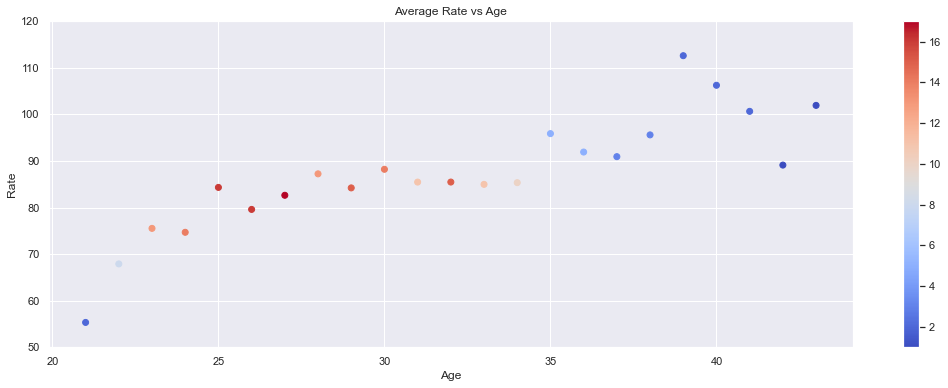

In [67]:
plot_avg_var_by_year(case_avg, 'Rate')

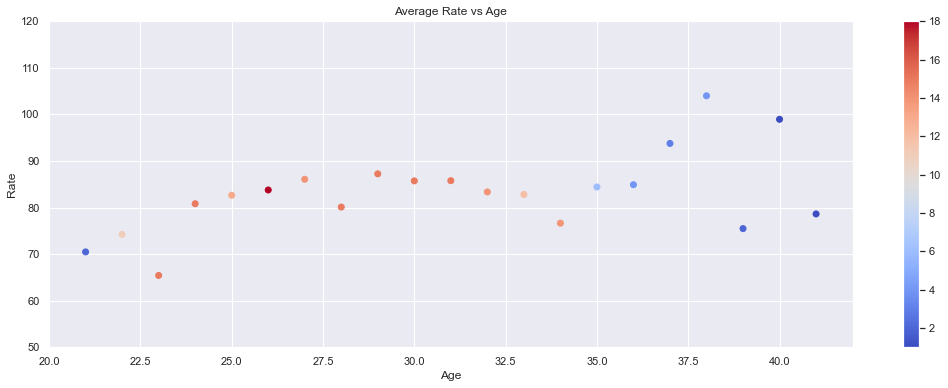

In [68]:
plot_avg_var_by_year(ctrl_avg, 'Rate')

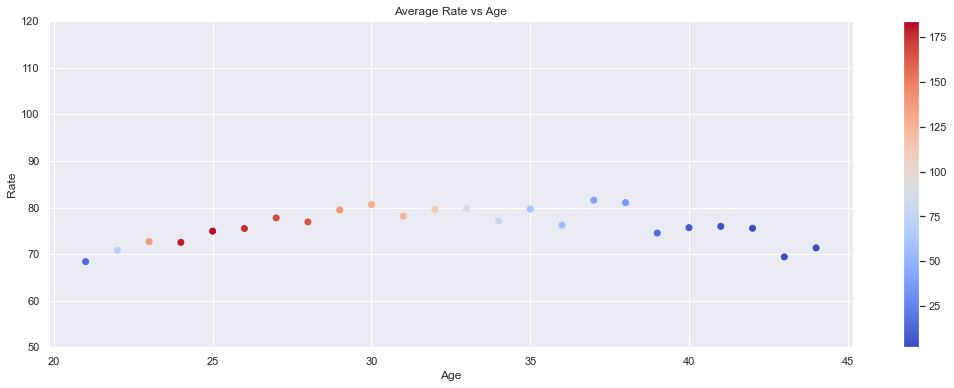

In [69]:
plot_avg_var_by_year(pop_avg, 'Rate')

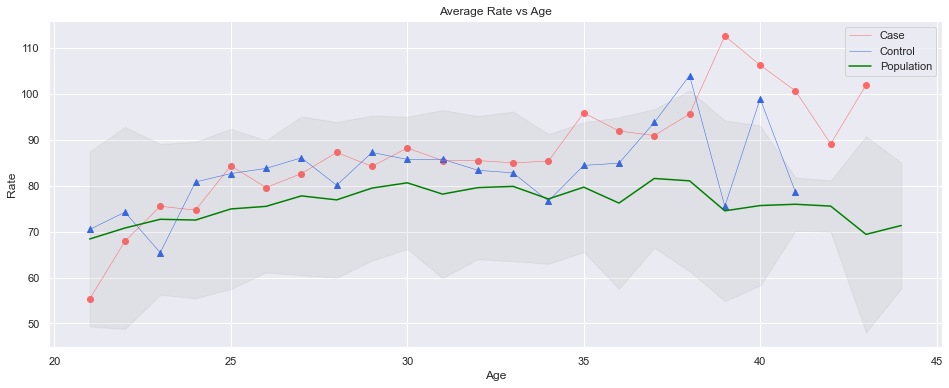

In [70]:
plot_case_ctrl_pop(case_avg, ctrl_avg, pop_avg, 'Rate')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

(4,)
(6,)
(6,)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

(5,)
(4,)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

(5,)
(11,)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

(5,)
(3,)
(5,)
(5,)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

(4,)
(2,)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

(8,)
(2,)
(7,)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

(4,)
(3,)
(9,)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


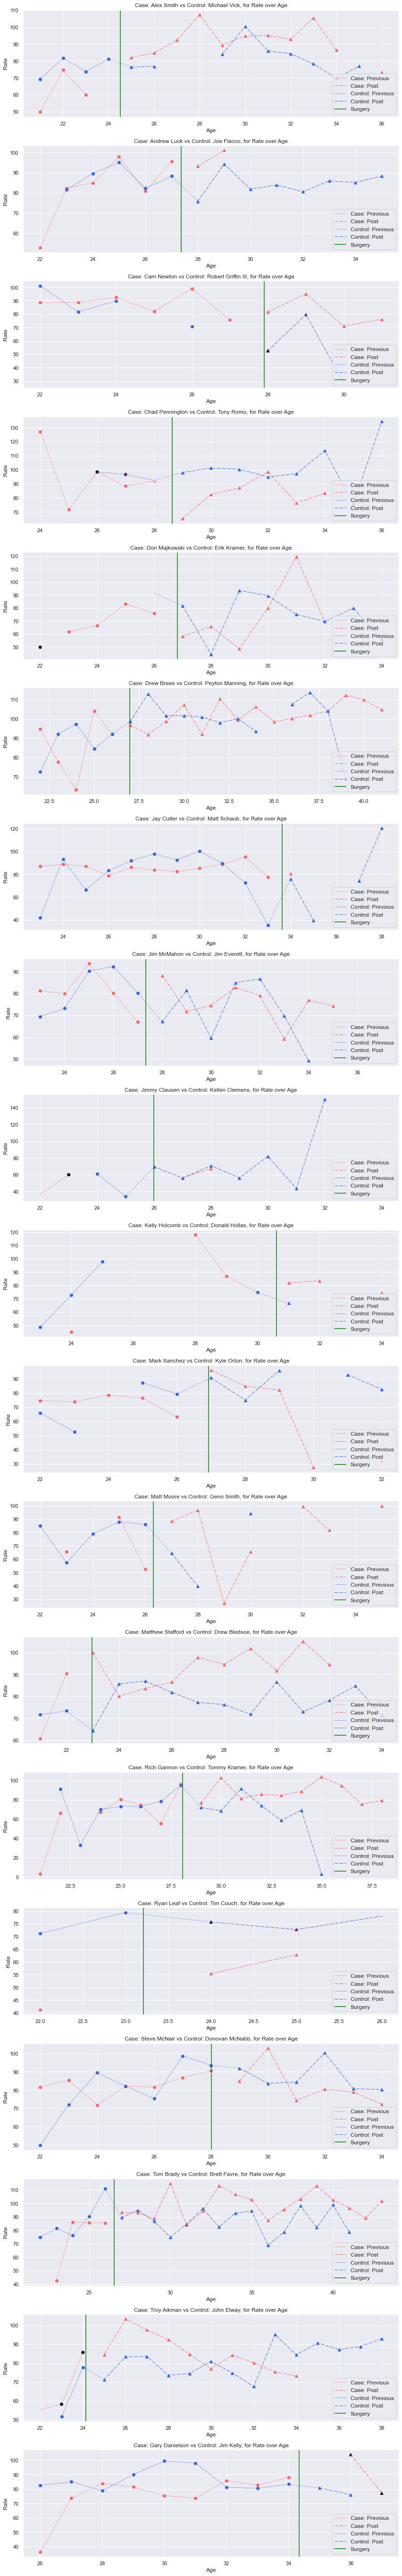

In [102]:
plot_case_control_by_year(case_qbs, select_ctrls, 'Rate');